In [1]:
%pylab inline
import pandas as pd
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam
import seaborn as sns
from scipy.sparse import csr_matrix
from datetime import timedelta
from keras import backend as K
from keras import losses, metrics

K.tensorflow_backend._get_available_gpus()

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from sklearn.decomposition import PCA

In [3]:
df_metadata = pd.read_csv('../data/sales_train_evaluation.csv', usecols=['dept_id', 'cat_id', 'store_id', 'state_id'])
# df_sell_prices = pd.read_csv('../data/sell_prices.csv')
df_calendar = pd.read_pickle('../data/processed/calendar_OHE.pkl')

In [4]:
calendar_array = df_calendar.sort_values('date').drop(['date','wm_yr_wk', 'd'], axis=1).astype(int).values
calendar_array = np.expand_dims(calendar_array, axis=0)
calendar_array.shape

(1, 1969, 53)

In [5]:
pca_calendar = PCA(n_components=3)
calendar_array_transformed = pca_calendar.fit_transform(df_calendar.sort_values('date').drop(['date','wm_yr_wk', 'd'], axis=1).astype(int))

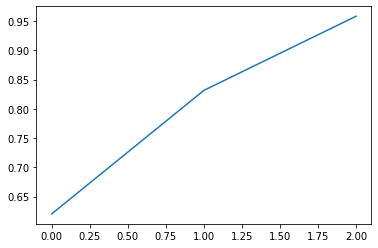

In [6]:
plot(pca_calendar.explained_variance_ratio_.cumsum())

In [7]:
metadata_array = pd.get_dummies(df_metadata).values

In [8]:
pca_meta = PCA(n_components=14)
metadata_array_transformed = pca_meta.fit_transform(metadata_array)

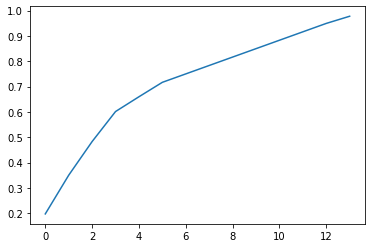

In [9]:
plot(pca_meta.explained_variance_ratio_.cumsum())

In [10]:
metadata_array_transformed_f16 = metadata_array_transformed.astype('float16')

In [11]:
calendar_array_transformed_f16 = calendar_array_transformed.astype('float16')

In [15]:
pca_calendar.inverse_transform(calendar_array_transformed_f16).round()

array([[ 0.000e+00,  0.000e+00,  0.000e+00, ...,  1.000e+00,  1.000e+00,
         2.011e+03],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  2.000e+00,  1.000e+00,
         2.011e+03],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  3.000e+00,  1.000e+00,
         2.011e+03],
       ...,
       [-0.000e+00,  0.000e+00,  0.000e+00, ...,  7.000e+00,  6.000e+00,
         2.016e+03],
       [ 0.000e+00,  0.000e+00, -0.000e+00, ...,  1.000e+00,  6.000e+00,
         2.016e+03],
       [ 0.000e+00,  0.000e+00, -0.000e+00, ...,  2.000e+00,  6.000e+00,
         2.016e+03]])

In [22]:
a = all(calendar_array == pca_calendar.inverse_transform(calendar_array_transformed_f16).round())
np.size(a) - np.count_nonzero(a)

1

In [23]:
a = all(metadata_array == pca_meta.inverse_transform(metadata_array_transformed_f16).round())
np.size(a) - np.count_nonzero(a)

1